# Not Just Pretty Pictures Demo

minimal working example of Stable Diffusion augmentation using text prompts

sources:
- largely following [this example](https://huggingface.co/docs/diffusers/api/pipelines/overview#imagetoimage-textguided-generation-with-stable-diffusion)


## setup

In [1]:
# boilerplate

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

# get transformers to shut up
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
!pip install --upgrade diffusers transformers scipy
!pip install imagecorruptions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 KB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 77.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.8 MB/s eta 0:00:00


In [3]:
import sys
import torch
import numpy as np
from PIL import Image
from IPython.display import display, HTML, display_html
from tqdm.notebook import tqdm_notebook as tqdm
from torch import autocast
import torchvision.transforms as T
from diffusers import StableDiffusionImg2ImgPipeline
from huggingface_hub import notebook_login
import random
from math import sqrt
# huggingface token login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [4]:
# generic visualization
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## img2img (no textual inversion)

In [5]:
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    'CompVis/stable-diffusion-v1-4',
    torch_dtype=torch.float16,
).to('cuda')

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [6]:
# Stable Diffusion Augmentation
def Generator_augment(init_img_path, prompt, pipe):
    with autocast('cuda'):
        init_image = Image.open(init_img_path).resize((512, 512))
        images = pipe(
            prompt=[prompt]*1, init_image=init_image,
            num_inference_steps=50, 
            strength=0.9, guidance_scale=7.5).images
    return  images[0]


In [7]:
# AugMix Augmentation
def AugMix_augment(init_img_path):
    init_image = Image.open(init_img_path).resize((512, 512))
    augmix = T.AugMix()
    img = augmix(init_image)
    return img


In [8]:
# RandAugment Augmentation
def RandAugment_augment(init_img_path):
    init_image = Image.open(init_img_path).resize((512, 512))
    RandAugment = T.RandAugment()
    img = RandAugment(init_image)
    return img

In [9]:
# CutOut Augmentation
# Adapted from https://github.com/uoguelph-mlrg/Cutout/blob/master
def CutOut_augment(init_img_path):
    n_holes = 1
    length = 72
    i2t = T.ToTensor()
    t2i = T.ToPILImage()
    init_img = i2t(Image.open(init_img_path).resize((512, 512)))

    h,w = init_img.size(1), init_img.size(2)
    mask = np.ones((h, w), np.float32)

    for n in range(n_holes):
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - length // 2, 0, h)
        y2 = np.clip(y + length // 2, 0, h)
        x1 = np.clip(x - length // 2, 0, w)
        x2 = np.clip(x + length // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.

    mask = torch.from_numpy(mask)
    mask = mask.expand_as(init_img)
    img = t2i(init_img * mask)
    return img

In [10]:
# MixUp Augmentation
# Adapted from https://github.com/moskomule/mixup.pytorch
def MixUp_augment(init_img_path, all_img_path):
    alpha = 0.5
    init_img = np.asarray(Image.open(init_img_path).resize((512, 512)))
    comp_img_path = random.choice([i for i in all_img_path if i != init_img_path])
    comp_img = np.asarray(Image.open(comp_img_path).resize((512, 512)))
    # print(init_img / 255, comp_img.shape)
    img = ((1 - alpha) * (init_img) + (alpha) * comp_img) 
    img = Image.fromarray(np.uint8(img))
    return img


In [11]:
# CutMix Augmentation
# Adapted from https://github.com/ildoonet/cutmix
def rand_bbox(size, lam):
    if len(size) == 4:
        W = size[2]
        H = size[3]
    elif len(size) == 3:
        W = size[1]
        H = size[2]
    else:
        raise Exception

    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def CutMix_augment(init_img_path, all_img_path):
    beta = 1
    lam = np.random.beta(beta, beta)
    i2t = T.ToTensor()
    t2i = T.ToPILImage()
    init_img = i2t(Image.open(init_img_path).resize((512, 512)))
    comp_img_path = random.choice([i for i in all_img_path if i != init_img_path])
    comp_img = i2t(Image.open(comp_img_path).resize((512, 512)))

    bbx1, bby1, bbx2, bby2 = rand_bbox(init_img.size(), lam)
    init_img[:, bbx1:bbx2, bby1:bby2] = comp_img[:, bbx1:bbx2, bby1:bby2]
    img = t2i(init_img)
    return img


In [12]:
# CIRL Augmentation
# Adapted from https://github.com/BIT-DA/CIRL/blob/main/data/DGDataReader.py
def colorful_spectrum_mix(img1, img2, alpha, ratio=1.0):
    """Input image size: ndarray of [H, W, C]"""
    lam = np.random.uniform(0, alpha)

    assert img1.shape == img2.shape
    h, w, c = img1.shape
    h_crop = int(h * sqrt(ratio))
    w_crop = int(w * sqrt(ratio))
    h_start = h // 2 - h_crop // 2
    w_start = w // 2 - w_crop // 2

    img1_fft = np.fft.fft2(img1, axes=(0, 1))
    img2_fft = np.fft.fft2(img2, axes=(0, 1))
    img1_abs, img1_pha = np.abs(img1_fft), np.angle(img1_fft)
    img2_abs, img2_pha = np.abs(img2_fft), np.angle(img2_fft)

    img1_abs = np.fft.fftshift(img1_abs, axes=(0, 1))
    img2_abs = np.fft.fftshift(img2_abs, axes=(0, 1))

    img1_abs_ = np.copy(img1_abs)
    img2_abs_ = np.copy(img2_abs)
    img1_abs[h_start:h_start + h_crop, w_start:w_start + w_crop] = \
        lam * img2_abs_[h_start:h_start + h_crop, w_start:w_start + w_crop] + (1 - lam) * img1_abs_[
                                                                                          h_start:h_start + h_crop,
                                                                                          w_start:w_start + w_crop]
    img2_abs[h_start:h_start + h_crop, w_start:w_start + w_crop] = \
        lam * img1_abs_[h_start:h_start + h_crop, w_start:w_start + w_crop] + (1 - lam) * img2_abs_[
                                                                                          h_start:h_start + h_crop,
                                                                                          w_start:w_start + w_crop]

    img1_abs = np.fft.ifftshift(img1_abs, axes=(0, 1))
    img2_abs = np.fft.ifftshift(img2_abs, axes=(0, 1))

    img21 = img1_abs * (np.e ** (1j * img1_pha))
    img12 = img2_abs * (np.e ** (1j * img2_pha))
    img21 = np.real(np.fft.ifft2(img21, axes=(0, 1)))
    img12 = np.real(np.fft.ifft2(img12, axes=(0, 1)))
    img21 = np.uint8(np.clip(img21, 0, 255))
    img12 = np.uint8(np.clip(img12, 0, 255))

    return img21, img12

def CIRL_augment(init_img_path, all_img_path):
    alpha = 1
    i2t = T.ToTensor()
    t2i = T.ToPILImage()
    init_img = np.asarray(Image.open(init_img_path).resize((512, 512)))
    comp_img_path = random.choice([i for i in all_img_path if i != init_img_path])
    comp_img = np.asarray(Image.open(comp_img_path).resize((512, 512)))
    init_img, comp_img = colorful_spectrum_mix(init_img, comp_img, alpha=alpha)
    img = Image.fromarray(init_img)

    return img

In [13]:
# ACVC Augmentation
# Adapted from https://github.com/ExplainableML/ACVC

from imagecorruptions import corrupt, get_corruption_names

def get_severity():
    return np.random.randint(1, 6)

def draw_cicle(shape, diamiter):
    """
    Input:
    shape    : tuple (height, width)
    diameter : scalar
    Output:
    np.array of shape  that says True within a circle with diamiter =  around center
    """
    assert len(shape) == 2
    TF = np.zeros(shape, dtype="bool")
    center = np.array(TF.shape) / 2.0

    for iy in range(shape[0]):
        for ix in range(shape[1]):
            TF[iy, ix] = (iy - center[0]) ** 2 + (ix - center[1]) ** 2 < diamiter ** 2
    return TF

def filter_circle(TFcircle, fft_img_channel):
    temp = np.zeros(fft_img_channel.shape[:2], dtype=complex)
    temp[TFcircle] = fft_img_channel[TFcircle]
    return temp

def inv_FFT_all_channel(fft_img):
    img_reco = []
    for ichannel in range(fft_img.shape[2]):
        img_reco.append(np.fft.ifft2(np.fft.ifftshift(fft_img[:, :, ichannel])))
    img_reco = np.array(img_reco)
    img_reco = np.transpose(img_reco, (1, 2, 0))
    return img_reco

def high_pass_filter(x, severity):
    x = x.astype("float32") / 255.
    c = [.01, .02, .03, .04, .05][severity - 1]

    d = int(c * x.shape[0])
    TFcircle = draw_cicle(shape=x.shape[:2], diamiter=d)
    TFcircle = ~TFcircle

    fft_img = np.zeros_like(x, dtype=complex)
    for ichannel in range(fft_img.shape[2]):
        fft_img[:, :, ichannel] = np.fft.fftshift(np.fft.fft2(x[:, :, ichannel]))

    # For each channel, pass filter
    fft_img_filtered = []
    for ichannel in range(fft_img.shape[2]):
        fft_img_channel = fft_img[:, :, ichannel]
        temp = filter_circle(TFcircle, fft_img_channel)
        fft_img_filtered.append(temp)
    fft_img_filtered = np.array(fft_img_filtered)
    fft_img_filtered = np.transpose(fft_img_filtered, (1, 2, 0))
    x = np.clip(np.abs(inv_FFT_all_channel(fft_img_filtered)), a_min=0, a_max=1)

    x = Image.fromarray((x * 255.).astype("uint8"))
    return x

def constant_amplitude(x, severity):
    """
    A visual corruption based on amplitude information of a Fourier-transformed image
    Adopted from: https://github.com/MediaBrain-SJTU/FACT
    """
    x = x.astype("float32") / 255.
    c = [.05, .1, .15, .2, .25][severity - 1]

    # FFT
    x_fft = np.fft.fft2(x, axes=(0, 1))
    x_abs, x_pha = np.fft.fftshift(np.abs(x_fft), axes=(0, 1)), np.angle(x_fft)

    # Amplitude replacement
    beta = 1.0 - c
    x_abs = np.ones_like(x_abs) * max(0, beta)

    # Inverse FFT
    x_abs = np.fft.ifftshift(x_abs, axes=(0, 1))
    x = x_abs * (np.e ** (1j * x_pha))
    x = np.real(np.fft.ifft2(x, axes=(0, 1)))

    x = Image.fromarray((x * 255.).astype("uint8"))
    return x

def phase_scaling(x, severity):
    """
    A visual corruption based on phase information of a Fourier-transformed image
    Adopted from: https://github.com/MediaBrain-SJTU/FACT
    """
    x = x.astype("float32") / 255.
    c = [.1, .2, .3, .4, .5][severity - 1]

    # FFT
    x_fft = np.fft.fft2(x, axes=(0, 1))
    x_abs, x_pha = np.fft.fftshift(np.abs(x_fft), axes=(0, 1)), np.angle(x_fft)

    # Phase scaling
    alpha = 1.0 - c
    x_pha = x_pha * max(0, alpha)

    # Inverse FFT
    x_abs = np.fft.ifftshift(x_abs, axes=(0, 1))
    x = x_abs * (np.e ** (1j * x_pha))
    x = np.real(np.fft.ifft2(x, axes=(0, 1)))

    x = Image.fromarray((x * 255.).astype("uint8"))
    return x

def apply_corruption(x, corruption_name):
    severity = get_severity()

    custom_corruptions = {"high_pass_filter": high_pass_filter,
                          "constant_amplitude": constant_amplitude,
                          "phase_scaling": phase_scaling}

    if corruption_name in get_corruption_names('all'):
        x = corrupt(x, corruption_name=corruption_name, severity=severity)
        x = Image.fromarray(x)

    elif corruption_name in custom_corruptions:
        x = custom_corruptions[corruption_name](x, severity=severity)

    else:
        assert True, "%s is not a supported corruption!" % corruption_name

    return x

def acvc(x):
    i = np.random.randint(0, 22)
    corruption_func = {0: "fog",
                        1: "snow",
                        2: "frost",
                        3: "spatter",
                        4: "zoom_blur",
                        5: "defocus_blur",
                        6: "glass_blur",
                        7: "gaussian_blur",
                        8: "motion_blur",
                        9: "speckle_noise",
                        10: "shot_noise",
                        11: "impulse_noise",
                        12: "gaussian_noise",
                        13: "jpeg_compression",
                        14: "pixelate",
                        15: "elastic_transform",
                        16: "brightness",
                        17: "saturate",
                        18: "contrast",
                        19: "high_pass_filter",
                        20: "constant_amplitude",
                        21: "phase_scaling"}
    return apply_corruption(x, corruption_func[i])


def ACVC_augment(init_img_path):
  init_img = np.asarray(Image.open(init_img_path).resize((512, 512)))
  x_ = acvc(init_img)
  return x_


In [14]:
def get_all_augmentation(init_img_path, prompt, pipe):
    all_images = []
    all_images.append(Image.open(init_img_path).resize((512,512)))
    all_images.append(Generator_augment(init_img_path, prompt, pipe))
    all_images.append(AugMix_augment(init_img_path))    
    all_images.append(RandAugment_augment(init_img_path))
    all_images.append(CutOut_augment(init_img_path))
    all_images.append(MixUp_augment(init_img_path, all_img_path))
    all_images.append(CutMix_augment(init_img_path, all_img_path))
    all_images.append(CIRL_augment(init_img_path, all_img_path))
    all_images.append(ACVC_augment(init_img_path))

    return all_images



In [16]:
# Load all samples images
# Use sample images provided in ./Demo in the github repo or customised with more than 2 sample images
all_img_path = ['dog.jpg','elephant.jpg','art_dog.jpg','giraffe.jpg','horse.jpg']

In [ ]:
# Visualise Different Augmentation Methods
# Results shown in order: Original Image/Generative Model Manipulation/AugMix/RandAugment/CutOut/MixUp/CutMix/CIRL/ACVC
init_img_path = 'dog.jpg'
prompt = 'a cartoon of the dog'

all_images = get_all_augmentation(init_img_path, prompt, pipe)
grid = image_grid(all_images, 3, 3)
grid

Output hidden; open in https://colab.research.google.com to view.

In [22]:
init_img_path = 'elephant.jpg'
prompt = 'a sketch of the elephant'

all_images = get_all_augmentation(init_img_path, prompt, pipe)
grid = image_grid(all_images, 3, 3)
grid

Output hidden; open in https://colab.research.google.com to view.

In [17]:
init_img_path = 'art_dog.jpg'
prompt = 'a photo of the dog'

all_images = get_all_augmentation(init_img_path, prompt, pipe)
grid = image_grid(all_images, 3, 3)
grid

Output hidden; open in https://colab.research.google.com to view.

  0%|          | 0/45 [00:00<?, ?it/s]

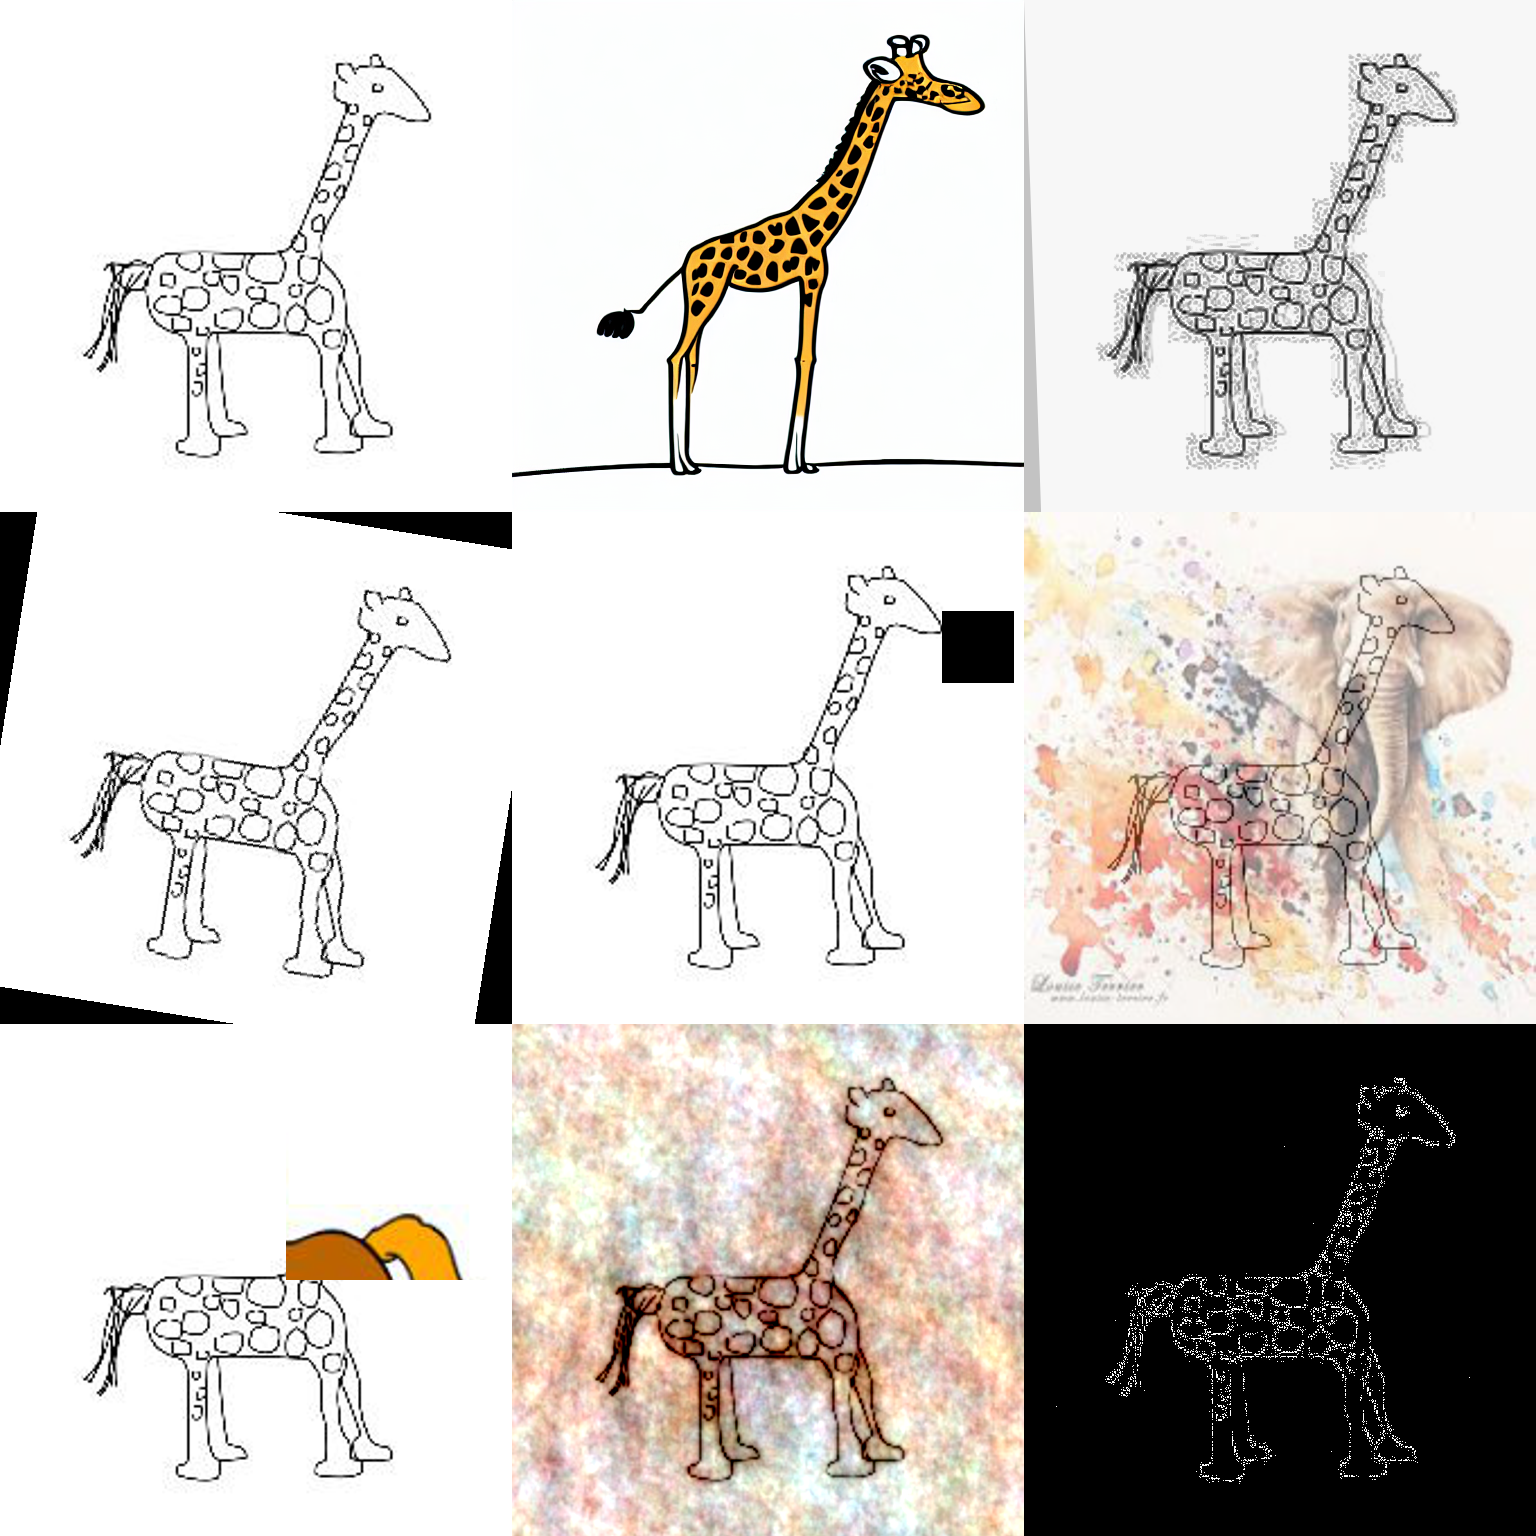

In [18]:
init_img_path = 'giraffe.jpg'
prompt = 'a cartoon of the giraffe'

all_images = get_all_augmentation(init_img_path, prompt, pipe)
grid = image_grid(all_images, 3, 3)
grid

In [20]:
init_img_path = 'horse.jpg'
prompt = 'a sketch of the horse'

all_images = get_all_augmentation(init_img_path, prompt, pipe)
grid = image_grid(all_images, 3, 3)
grid

Output hidden; open in https://colab.research.google.com to view.